# Recreación del paper de lxs brasileñxs. 

Por cada columna del dataset, se hará un _Random Forest_ de Sklearn donde la variable objetivo será la columna actual y se predecirá con el resto.

El resultado será un archivo csv llamado pesos.csv con una matriz que representa un grafo pesado dirigido. Las filas serán el origen y las columnas el objetivo. Así cada vez que se obtenga un resultado del _Random Forest_, se agregará una columna al dataset y si peso hacia sí mismo será nulo.

## Algoritmo a seguir

1. Leer los datos de la endireh preprocesados con discretización del parámetro P9_8.
2. Obtener dos columnas por tipo de violencia ('P9_8_abuso', 'P9_8_atencion').
3. Crear un dataframe de pandas con los nombres de las columnas como índice.
4. Iterar sobre las columnas como variable objetivo. Por cada iteración:
        a. crear un random forest y obtener el feature importance.
        b. agregar los feature importance al dataframe creado en el paso 3, respetando el orden predefinido.
        c. asegurando que a sí mismo sea nan.
        d. guardar el archivo csv (para no perder progreso).

In [1]:
# Custom functions
# ==============================================================================
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import multiprocessing
#from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV,ParameterGrid

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
def grid(param_grid, X, y, cv=5):
    #hacer grid search
    grid = GridSearchCV(XGBClassifier(), param_grid, cv=cv, scoring='f1_micro', verbose=1, error_score="raise")
    
    #hacer fit
    grid.fit(X, y)
    
    #imprimir mejores parametros y score
    print(f'f1: {grid.best_score_}')
    
    return grid.best_estimator_.feature_importances_

In [3]:
def clasificacionAbuso(row):
    if row['P9_8'] == 1 or row['P9_8'] == 3:
        return 1
    return 0

def clasificacionAtencion(row):

    if row['P9_8'] == 2 or row['P9_8'] == 3:
        return 1
    return 0


## 1. Cargar datos

In [4]:
endireh = CargarPandasDatasetCategoricos('data/endireh.csv')

In [5]:
endireh.columns

Index(['CVE_ENT', 'REGION', 'DOMINIO', 'T_INSTRUM', 'ESTRATO', 'PISOS', 'P1_2',
       'P1_2_A', 'FOCOS', 'P1_4_1', 'P1_4_2', 'P1_4_3', 'P1_4_4', 'P1_4_5',
       'P1_4_6', 'P1_4_7', 'P1_4_8', 'P1_4_9', 'AGUA', 'DRENAJE', 'P1_7',
       'P1_9', 'P1_10_1', 'P1_10_2', 'P1_10_3', 'P1_10_4', 'PAREN', 'EDAD',
       'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRA', 'ALFABETISMO',
       'ASISTENCIA_ESC', 'PERT_INDIGENA', 'LENG_INDIGENA', 'LENG_ESPAÑOL',
       'TRABAJO', 'P2_14', 'P2_15', 'P9_1', 'P9_3', 'NACIO_VIV', 'NACIO_MUERT',
       'ABORTO', 'P9_5', 'P9_6', 'P9_7', 'P9_8'],
      dtype='object')

Ninguno:	64.6%
Abuso y violencia:	26.4%
Atencion no autorizada:	18.2%


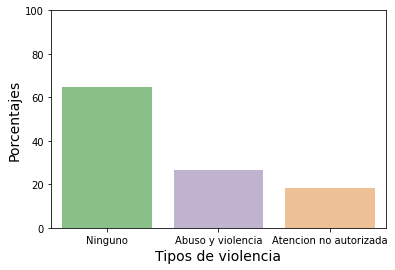

In [6]:
# obtengo las categorias y su cantidad de concurrencias
ocurrencias = endireh["P9_8"].value_counts()
# obtengo los porcentajes con 1 decimal de los tipos 'Ninguno', ' Abuso y violencia' y 'Atencion no autorizada'
ocurrencias = np.around((np.array([ocurrencias[0], ocurrencias[1]+ocurrencias[3], ocurrencias[2]+ocurrencias[3]])/ocurrencias.sum())*1000)/10
groups = ['Ninguno',  'Abuso y violencia', 'Atencion no autorizada']

# imprimo los porcentajes
for i,j in zip(groups, ocurrencias):
    print(f'{i}:\t{j}%')

sns.barplot(x=groups, y=ocurrencias, palette = 'Accent')
plt.xlabel('Tipos de violencia', fontsize=14)
plt.ylabel('Porcentajes', fontsize=14)
plt.ylim([0, 100])
plt.show()

## Algoritmo a seguir

1. Leer los datos de la endireh preprocesados con discretización del parámetro P9_8.
2. Obtener dos columnas por tipo de violencia ('P9_8_abuso', 'P9_8_atencion').
3. Crear un dataframe de pandas con los nombres de las columnas como índice.
4. Iterar sobre las columnas como variable objetivo. Por cada iteración:
        a. crear un random forest y obtener el feature importance.
        b. agregar el feature importance al dataframe creado en 3, respetando el orden predefinido.
        c. asegurando que a sí mismo sea nan.
        d. guardar el archivo csv (para no perder progreso).

## Preprocesamiento


Eliminando los de ambos y ninguno

In [7]:
endireh.columns

Index(['CVE_ENT', 'REGION', 'DOMINIO', 'T_INSTRUM', 'ESTRATO', 'PISOS', 'P1_2',
       'P1_2_A', 'FOCOS', 'P1_4_1', 'P1_4_2', 'P1_4_3', 'P1_4_4', 'P1_4_5',
       'P1_4_6', 'P1_4_7', 'P1_4_8', 'P1_4_9', 'AGUA', 'DRENAJE', 'P1_7',
       'P1_9', 'P1_10_1', 'P1_10_2', 'P1_10_3', 'P1_10_4', 'PAREN', 'EDAD',
       'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRA', 'ALFABETISMO',
       'ASISTENCIA_ESC', 'PERT_INDIGENA', 'LENG_INDIGENA', 'LENG_ESPAÑOL',
       'TRABAJO', 'P2_14', 'P2_15', 'P9_1', 'P9_3', 'NACIO_VIV', 'NACIO_MUERT',
       'ABORTO', 'P9_5', 'P9_6', 'P9_7', 'P9_8'],
      dtype='object')

In [8]:
endireh = InsertarColumnaNueva(df=endireh, nombreCol='P9_8_abuso',    numeroCol=49, funcion=clasificacionAbuso)
endireh = InsertarColumnaNueva(df=endireh, nombreCol='P9_8_atencion', numeroCol=50, funcion=clasificacionAtencion)

In [9]:
endireh.drop(columns=['P9_8'], inplace=True)

Eliminar CVE_ENT porque los registros regionales no la tienen para comparar con el nacional, así que se elimina en general.

In [10]:
endireh.shape

(18882, 50)

## Parametros para el _Random Forest_

In [11]:
param_grid = ParameterGrid(
                {
                 'n_estimators'       : [[150]],
                 'max_depth'          : [[6]],
                 'max_leaves'         : [range(150, 200, 3)], #2
                 'grow_policy'        : [[0,1]],
                 #'n_jobs'             : [[-1]],
                 'random_state'       : [[5]],
                 
                 'tree_method'        : [['hist']],
                 'importance_type'    : [['total_gain']],
                 'eval_metric'        : [[f1_score]],
                 'enable_categorical' : [[True]],
                 #'missing'            : [[99]],
                 'use_label_encoder'  : [[False]],
                }
            )


# Nacional


Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [12]:
endireh_nac = endireh.drop(columns=['REGION', 'DOMINIO'], inplace=False)

## Crear dataframe de salida

In [13]:
columnas = endireh_nac.columns

df = pd.DataFrame(index=columnas)
df.to_csv(f'data/pesos_nac.csv')
#df = pd.read_csv('data/pesos_nac.csv')

21:18 hrs del día martes 31 de mayo

In [18]:
%%time
for i in range(len(columnas)):
    if columnas[i] not in df.columns:
        print(columnas[i], i)
        # declarar la variable objetivo actual y sacarla de la matriz
        y = endireh_nac[columnas[i]].copy()
        X = endireh_nac.drop(columns=columnas[i], inplace=False)

        # hacer la búsqueda grid y obtener el feature importance
        fi = grid(param_grid, X, y)

        # insertar el valor nan a la columna actual
        fi = np.insert(fi, i, np.nan)

        # agregarlo como nueva columna 
        df[columnas[i]] = fi

        # guardar el archivo
        df.to_csv('data/pesos_nac.csv')

        print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()), '\n')

T_INSTRUM 0
Fitting 5 folds for each of 34 candidates, totalling 170 fits


ValueError: Experimental support for categorical data is not implemented for current tree method yet.

# Regional

In [13]:
endireh['REGION'].value_counts()

4    3768
1    3208
3    3100
0    2893
6    1904
7    1859
5    1165
2    1003
Name: REGION, dtype: int64

In [14]:
endireh_nac = endireh.drop(columns=['DOMINIO'], inplace=False)

In [15]:
columnas = endireh_nac.drop(columns='REGION', inplace=False).columns

In [19]:
gk = endireh_nac.groupby('REGION')

In [20]:
%%time
for reg in [str(i) for i in range(8)]:
    print(reg)
    X_group = gk.get_group(reg)
    X_group.drop(columns='REGION', inplace=True)
    df = pd.read_csv(f'data/pesos_reg_{reg}.csv', index_col='Unnamed: 0')
    for i in range(len(columnas)):
        if columnas[i] not in df.columns:
            print(columnas[i], i)
            # declarar la variable objetivo actual y sacarla de la matriz
            y = X_group[columnas[i]].copy()
            X = X_group.drop(columns=columnas[i], inplace=False)

            # hacer la búsqueda grid y obtener el feature importance
            fi = grid(param_grid, X, y)

            # insertar el valor nan a la columna actual
            fi = np.insert(fi, i, np.nan)

            # agregarlo como nueva columna 
            df[columnas[i]] = fi

            # guardar el archivo
            df.to_csv(f'data/pesos_reg_{reg}.csv')

            print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()), '\n')

0


KeyError: '0'

# DOMINIO

In [17]:
endireh['DOMINIO'].value_counts()

2    7888
1    5672
0    5340
Name: DOMINIO, dtype: int64

In [14]:
endireh.drop(columns='REGION', inplace=True)

In [15]:
columnas = endireh.drop(columns='DOMINIO', inplace=False).columns

In [16]:
#Crear los dataset

for reg in [str(i) for i in range(3)]:
    df = pd.DataFrame(index=columnas)
    df.to_csv(f'data/pesos_dom_{reg}.csv')

In [24]:
gk = endireh.groupby('DOMINIO')

In [25]:
%%time
for dom in [str(i) for i in range(3)]:
    print(dom)
    X_group = gk.get_group(f'{str(dom)}.0')
    X_group.drop(columns='DOMINIO', inplace=True)
    df = pd.read_csv(f'data/pesos_dom_{dom}.csv', index_col='Unnamed: 0')
    for i in range(len(columnas)):
        if columnas[i] not in df.columns:
            print(columnas[i], i)
            # declarar la variable objetivo actual y sacarla de la matriz
            y = X_group[columnas[i]].copy()
            X = X_group.drop(columns=columnas[i], inplace=False)

            # hacer la búsqueda grid y obtener el feature importance
            fi = grid(param_grid, X, y)

            # insertar el valor nan a la columna actual
            fi = np.insert(fi, i, np.nan)

            # agregarlo como nueva columna 
            df[columnas[i]] = fi

            # guardar el archivo
            df.to_csv(f'data/pesos_dom_{dom}.csv')

            print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()), '\n')

0


KeyError: '0.0'

# Código que me puede ayudar después

        y = endireh[['P9_8_abuso', 'P9_8_atencion']].copy()
        endireh.drop(columns=['P9_8_abuso', 'P9_8_atencion'], inplace=True)
---